# XGB model hyperparameters tuning

- `xgboost.cv`
- Comparing the optimal candidates by test set, using the g-research weighted correlation metrics.

In [15]:
import os
import pandas as pd
import gc
import talib as ta
import numpy as np

## 1. cv tuned model folders

- `model_nof_{version number}`

In [16]:

sorted([int(s.split('_')[-1]) for s in os.listdir('./trainedXGB/') if 'model_nof' in s])[-4:]

[26, 27, 28, 29]

## 2. organized data set  

- new_data.ftr

In [17]:
df_train = pd.read_feather('./data'+'/new_data.ftr')
df_train.tail()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,...,Crypto_Index,vol_sum_15,std_lr_15,std_Mkt_lrt_15,std_Crypto_Index,lrtn_index_5,lrtn_index_15,beta,lr_mkt_resid,lr_mkt_resid_sma
26473297,1641772800,9,218.0,130.842571,130.940000,130.478000,130.707429,1.011042e+03,130.734076,NaN,...,7532.261935,5.065137e+03,0.002495,0.002552,20.825669,-0.001497,-0.002382,0.963412,-0.001552,-0.001613
26473298,1641772800,10,20.0,2122.416667,2124.010000,2116.950000,2119.743333,2.084755e+00,2120.570582,NaN,...,7532.261935,2.962160e+01,0.005703,0.002552,20.825669,-0.001497,-0.002382,1.507092,0.001455,0.004368
26473299,1641772800,13,118.0,0.066109,0.066130,0.066058,0.066082,1.265238e+06,0.066086,NaN,...,7532.261935,1.020347e+07,0.002223,0.002552,20.825669,-0.001497,-0.002382,0.772527,-0.000973,-0.001959
26473300,1641772800,12,112.0,0.261055,0.261185,0.260474,0.260682,1.187581e+05,0.260913,NaN,...,7532.261935,1.559958e+06,0.003061,0.002552,20.825669,-0.001497,-0.002382,0.938556,-0.000505,-0.000335
26473301,1641772800,11,52.0,190.732000,191.160000,189.800000,190.506000,1.355932e+02,190.622811,NaN,...,7532.261935,8.948188e+02,0.003225,0.002552,20.825669,-0.001497,-0.002382,0.576140,0.001426,0.001444


Weighted info `lr_mkt_resid` similar to `Target` which can remove the market signal from individual asset returns. 

$$R^{a}(t)=\log P^{a}_t - \log P^{a}_{t-15}$$

$$M(t)=\frac{\sum_{a} w^{a} R^{a}(t)}{\sum_{a} w^{a}}$$

$$\beta^{a}=\frac{\left\langle M \cdot R^{a}\right\rangle_{60}}{\left\langle M^{2}\right\rangle_{60}}$$

$$lrmktresid^{a}(t)=R^{a}(t)-\beta^{a} M(t)$$

where the bracket  $⟨.⟩_{60}$ represent the rolling average over time (60 minute windows).

In [18]:
# df_train.set_index(['timestamp','Asset_ID'],inplace=True)
# def beta(df, window=60): 
#     b = (ta.MULT(df.Mkt_lrt_15,df.lr_15).rolling(window).mean())/(ta.MULT(df.Mkt_lrt_15,df.Mkt_lrt_15).rolling(window).mean())
#     return b

# def lr_mkt_resid(df):
#     return ta.SUB(df.lr_15, ta.MULT(df.beta, df.Mkt_lrt_15))

# ##make beta
# ddd = df_train.groupby("Asset_ID").apply(lambda x: beta(x)).rename("beta").to_frame().reset_index(0,drop=True)
# ddd=ddd.replace([np.nan,np.inf,-np.inf], 0)
# df_train= df_train.merge(ddd, on =['Asset_ID','timestamp'],how='left')

# ##make lr_mkt_resid
# df_train['lr_mkt_resid'] = lr_mkt_resid(df_train) 

# del ddd
# gc.collect()

# df_train.reset_index(inplace=True)
# df_train.tail()

## 3. Features

In [19]:
from script.XGB.xgbmodel import get_features
pd.options.mode.chained_assignment = None  # default='warn'
#import inspect
#from my_crypto_utility import *

def log_return(series, periods=5):
    return np.log(series).diff(periods)

def upper_shadow(df):
    return ta.SUB(df['High'], np.maximum(df['Close'], df['Open']))

def lower_shadow(df):
    return ta.SUB(np.minimum(df['Close'], df['Open']), df['Low'] )

def lag_features(df):    
    #tech analysis indicators, https://mrjbq7.github.io/ta-lib/funcs.html
    df['adx'] = ta.ADX(df['High'], df['Low'],df['Close'], timeperiod=30)#Average Directional Movement Index
    df['DI_plus'] = ta.PLUS_DI(df['High'], df['Low'],df['Close'], timeperiod=20)
    df['DI_minus'] = ta.MINUS_DI(df['High'], df['Low'],df['Close'], timeperiod=20)
    df['macd'],df['macd_signal'], df['macd_hist'] = ta.MACD(df['Close'], 
                                                                  fastperiod=5, slowperiod=30, signalperiod=5)
    #df['APO'] =ta.APO(df['Open'],fastperiod=12, slowperiod=26,)#Absolute Price Oscillator
    #df['PPO'] =ta.PPO(df['Open'])#percentage price oscillator
    df['TRENDLINE'] =ta.HT_TRENDLINE(df['Open'])#Hilbert Transform - Instantaneous Trendline
    df['MIDPOINT'] =ta.MIDPOINT(df['Open'])
    df['willr'] = ta.WILLR(df['High'], df['Low'],df['Close'], timeperiod=30)#Williams Percent Range
    df['rsi'] = ta.RSI(df['Close'], timeperiod=30)
    #df['CMO'] =ta.CMO(df['Open'])#Chande Momentum Oscillator
    band_up, mid_band, band_down = ta.BBANDS(df['Close'], timeperiod=30, nbdevup=2, nbdevdn=2, matype=0)
    df['close_bollinger_up'] = ta.SUB(band_up, df['Close'])
    df['close_bollinger_down'] = ta.SUB(df['Close'], band_down)
    ##volume
    df['AD'] = ta.AD(df['High'], df['Low'],df['Close'], df['Volume'])#Accumulation Distribution Line
    df['ADOSC'] = ta.ADOSC(df['High'], df['Low'],df['Close'], df['Volume'], fastperiod=10, slowperiod=30)
    ##volatility
    df['ATR'] = ta.ATR(df['High'], df['Low'],df['Close'], timeperiod=30)
    df['std_lr_15_15'] = ta.STDDEV(df.lr_15,timeperiod=5, nbdev=1)
    df['std_Mkt_lrt_15_15'] = ta.STDDEV(df.Mkt_lrt_15,timeperiod=5, nbdev=1)
    df['std_Crypto_Index_15'] = ta.STDDEV(df.Crypto_Index,timeperiod=5, nbdev=1)

def get_features(df_feat):
    pd.options.mode.chained_assignment = None  # default='warn'
    df_feat['Upper_Shadow'] = upper_shadow(df_feat)
    df_feat['Lower_Shadow'] = lower_shadow(df_feat)
    lag_features(df_feat)
    return df_feat

## 4. Test set range

- train set range is after `df_train['timestamp'].quantile(0.5)`
- test set

In [20]:
df_train['timestamp'].quantile(0.5)
pd.to_datetime(df_train['timestamp'].quantile(0.5),unit="s",
               infer_datetime_format=True)
int(pd.Timestamp('2021-09-21T00:00:00').timestamp())

1632182400

In [21]:
import datetime
import time

#test_days= 30*3
def make_testset(df_train, start,end):
    dd = df_train[(start<=df_train['timestamp']) & (df_train['timestamp']<=end)].copy()
    ###consistent timestamp for all 14 assets
    dd = dd.sort_values('timestamp').set_index("timestamp").sort_index()
    ind = dd.index.unique()
    def reindex(df):
        df = df.reindex(range(ind[0],ind[-1]+60,60),method='nearest')
        df = df.fillna(method="ffill").fillna(method="bfill")
        return df
    dd = dd.groupby('Asset_ID').apply(reindex).reset_index(0, drop=True).sort_index()
    ###add features
    dd = dd.groupby('Asset_ID').apply(lambda x: get_features(x))
    dd.dropna(axis = 0, inplace= True)
    return dd.reset_index()
    
################################################out-train test
test_end= df_train['timestamp'].max()
test_start= df_train['timestamp'].quantile(0.95)
df_test = make_testset(df_train, test_start,test_end)

#############################################in-train test same as API
test_end2= 1632182400
test_start2= 1623542400 - 60*64
df_test2 = make_testset(df_train, test_start2,test_end2)


In [22]:
del df_train
gc.collect()
df_test.tail()

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,...,willr,rsi,close_bollinger_up,close_bollinger_down,AD,ADOSC,ATR,std_lr_15_15,std_Mkt_lrt_15_15,std_Crypto_Index_15
1323541,1641772800,9,218.0,130.842571,130.940000,130.478000,130.707429,1.011042e+03,130.734076,-0.001335,...,-75.383200,40.156612,0.546360,0.079323,6.411318e+06,-1.587757e+02,0.231866,0.001116,0.001237,3.067078
1323542,1641772800,10,20.0,2122.416667,2124.010000,2116.950000,2119.743333,2.084755e+00,2120.570582,-0.003456,...,-48.718905,47.827923,15.012818,15.988340,3.783816e+03,3.209675e+00,3.908759,0.003268,0.001237,3.067079
1323543,1641772800,11,52.0,190.732000,191.160000,189.800000,190.506000,1.355932e+02,190.622811,-0.000454,...,-26.055777,52.116184,0.692726,1.208092,3.962212e+05,1.536563e+02,0.916299,0.001032,0.001237,3.067079
1323544,1641772800,12,112.0,0.261055,0.261185,0.260474,0.260682,1.187581e+05,0.260913,-0.000243,...,-51.762891,44.182993,0.001233,0.000716,1.377775e+09,-7.755757e+03,0.000469,0.001382,0.001237,3.067078
1323545,1641772800,13,118.0,0.066109,0.066130,0.066058,0.066082,1.265238e+06,0.066086,-0.000790,...,-64.846743,45.088782,0.000213,0.000190,8.406858e+08,-1.003177e+06,0.000090,0.000853,0.001237,3.067078


## Performance on test set

In [23]:
import xgboost as xgb
from os.path import exists

ASSET_DETAILS_CSV = './data/asset_details.csv'
df_asset_details = pd.read_csv(ASSET_DETAILS_CSV).sort_values("Asset_ID")

def model_reload_train(param_version):
    models = {}
    for asset_id, asset_name in zip(df_asset_details['Asset_ID'], df_asset_details['Asset_Name']):
        model_file = f"./trainedXGB/model_nof_{param_version}/model_{asset_id}.json"
        if exists(model_file):
            model = xgb.Booster()
            model.load_model(model_file)
            models[asset_id] = model
    return models

In [24]:
from script.weighted_corr_metrics import weighted_correlation

result = []
result2 = []
models = {}

for version_num in sorted([int(s.split('_')[-1]) for s in os.listdir('./trainedXGB/') if 'model_nof' in s])[-1:]:
    models[version_num] =model_reload_train(param_version= version_num)
    result_id=[]
    result_id2=[]
    for id in range(0,14):
        model = models[version_num][id]
        x = df_test[df_test['Asset_ID']==id]
        x['Pred'] = model.predict(xgb.DMatrix(x[model.feature_names]))
        result_id.append(x[['timestamp','Asset_ID','Weight','Target','Pred']])
        x2 = df_test2[df_test2['Asset_ID']==id]
        x2['Pred2'] = model.predict(xgb.DMatrix(x2[model.feature_names]))
        result_id2.append(x2[['timestamp','Asset_ID','Weight','Target','Pred2']])
        
    result.append(pd.concat(result_id, axis=0))
    result2.append(pd.concat(result_id2, axis=0))
    score=weighted_correlation(a=result[-1]['Target'], 
                     b=result[-1]['Pred'], 
                     weights=result[-1]['Weight'])
    score2=weighted_correlation(a=result2[-1]['Target'], 
                     b=result2[-1]['Pred2'], 
                     weights=result2[-1]['Weight'])
    #print(f"features: {models[0].feature_names}")
    print(f'model_nof_{version_num} finished. Out-train-score:{score}, In-train-score:{score2}')

model_nof_29 finished. Out-train-score:0.023083559726197612, In-train-score:0.28275541582029395


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

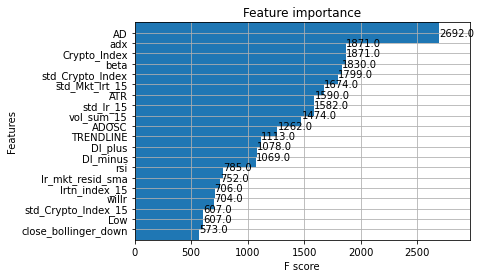

In [25]:
xgb.plot_importance(models[29][2], max_num_features=20, height=2)

In [26]:
models[29][5].feature_names

['Count',
 'Open',
 'High',
 'Low',
 'Close',
 'Volume',
 'lr_15',
 'Mkt_lrt_15',
 'Crypto_Index',
 'vol_sum_15',
 'std_lr_15',
 'std_Mkt_lrt_15',
 'std_Crypto_Index',
 'lrtn_index_5',
 'lrtn_index_15',
 'beta',
 'lr_mkt_resid',
 'lr_mkt_resid_sma',
 'Upper_Shadow',
 'Lower_Shadow',
 'adx',
 'DI_plus',
 'DI_minus',
 'macd',
 'macd_signal',
 'macd_hist',
 'TRENDLINE',
 'willr',
 'rsi',
 'close_bollinger_up',
 'close_bollinger_down',
 'AD',
 'ADOSC',
 'ATR',
 'std_lr_15_15',
 'std_Mkt_lrt_15_15',
 'std_Crypto_Index_15']

In [27]:
!cat trainedXGB/model_nof_25/params_xgb25.txt

{"booster": "gbtree", "verbosity": 0, "validate_parameters": 1, "learning_rate": 0.1, "min_split_loss": 0, "max_depth": 10, "min_child_weight": 0.6, "subsample": 0.7, "colsample_bytree": 0.3, "reg_lambda": 0.4, "reg_alpha": 1.2, "max_delta_step": 0, "scale_pos_weight": 1, "tree_method": "gpu_hist", "predictor": "gpu_predictor", "num_parallel_tree": 1, "objective": "reg:squarederror", "eval_metric": "rmse", "base_score": 0.5, "seed": 2021}